In [1]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 1 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 28.59 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


In [15]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from PIL import Image
import shutil
import copy

In [18]:
os.listdir('/content/PlantVillage-Dataset/raw/color/')

['Tomato___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Grape___Black_rot',
 'Raspberry___healthy',
 'Peach___Bacterial_spot',
 'Potato___Late_blight',
 'Grape___Esca_(Black_Measles)',
 'Corn_(maize)___Common_rust_',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Target_Spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Tomato___Leaf_Mold',
 'Apple___Apple_scab',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Soybean___healthy',
 'Strawberry___healthy',
 'Potato___healthy',
 'Corn_(maize)___healthy',
 'Apple___Black_rot',
 'Tomato___Early_blight',
 'Cherry_(including_sour)___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Apple___healthy',
 'Tomato___Bacterial_spot',
 'Cherry_(including_sour)___Powdery_mildew',
 'Pepper,_bell___healthy',
 'Tomato___Late_blight',
 'Apple___Cedar_apple_rust',
 'Potato___Early_blight',
 'Grape___healthy',
 'C

In [19]:
img = Image.open('/content/PlantVillage-Dataset/raw/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')

img_np = np.array(img)
img_np.shape

(256, 256, 3)

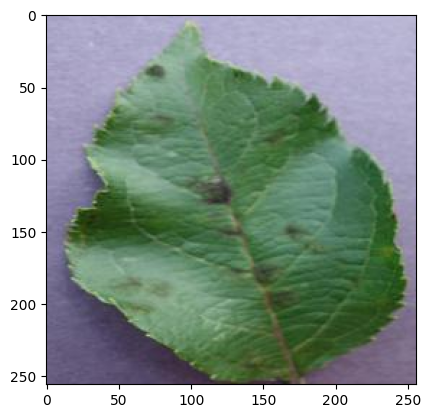

In [20]:
plt.imshow(img_np)

In [25]:
!mkdir forDataset
!mkdir forDataset/train
!mkdir forDataset/test

In [26]:
ini_data_dir = '/content/PlantVillage-Dataset/raw/color/'
out_dir = 'content/forDataset'
os.makedirs(out_dir + 'train', exist_ok=True)
os.makedirs(out_dir + 'test', exist_ok=True)
random.seed(42)

for class_name in os.listdir(ini_data_dir):
  class_dir = os.path.join(ini_data_dir, class_name)
  if not os.path.isdir(class_dir):
    continue

  files = os.listdir(class_dir)
  random.shuffle(files)

  split_len = len(files)
  train_split = int(split_len * 0.8)

  train_files = files[:train_split]
  test_files = files[train_split:]

  os.makedirs(os.path.join(out_dir, 'train', class_name), exist_ok=True)
  os.makedirs(os.path.join(out_dir, 'test', class_name), exist_ok=True)

  for f in train_files:
    shutil.copy(os.path.join(class_dir,f),os.path.join(out_dir,'train',class_name,f))

  for f in test_files:
    shutil.copy(os.path.join(class_dir,f),os.path.join(out_dir,'test',class_name,f))

In [27]:
shutil.move('content/forDataset','forDataset')

'forDataset'

In [28]:

train_dir = 'forDataset/train/'
val_dir = 'forDataset/val/'

os.makedirs(val_dir, exist_ok=True)

random.seed(42)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    files = os.listdir(class_path)
    random.shuffle(files)

    val_len = int(0.2 * len(files))
    val_files = files[:val_len]

    for f in val_files:
        shutil.move(os.path.join(class_path, f),
                    os.path.join(val_dir, class_name, f))

In [29]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [30]:
custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [32]:
base_dir = 'forDataset'

train_dataset = ImageFolder(root=f'{base_dir}/train', transform=custom_transform)
test_dataset = ImageFolder(root=f'{base_dir}/test', transform=custom_transform)
val_dataset = ImageFolder(root=f'{base_dir}/val', transform=custom_transform)

In [33]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False,pin_memory=True)

In [34]:
import torchvision.models as models

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = vgg16.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 98.6MB/s]


In [37]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
for param in vgg16.features.parameters():
  param.requires_grad = False

In [39]:
vgg16.classifier[6] = nn.Linear(4096,38)

In [ ]:
vgg16.shape

In [56]:
class model_tuning():
  def __init__(self,model,train_loader,test_loader,val_loader,device):
    self.device = device
    self.model = model.to(device)
    self.train_loader = train_loader
    self.test_loader = test_loader    # forgot to write initially
    self.val_loader = val_loader
    self.loss_fn = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(),lr=1e-4,weight_decay=1e-4)

    for param in self.model.features.parameters():
      param.requires_grad = False

  def calculate_loss(self,Y_pred,Y):
    return self.loss_fn(Y_pred,Y)

  def fit(self, epochs, plot_loss=False):
    if plot_loss:
        train_loss_store = {}
        val_loss_store = {}

    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(epochs):
        # ---------- Training ----------
        self.model.train()
        per_epoch_loss = 0

        for X_batch, Y_batch in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch = X_batch.to(self.device)
            Y_batch = Y_batch.to(self.device)

            Y_pred = self.model(X_batch)
            loss = self.calculate_loss(Y_pred, Y_batch)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            per_epoch_loss += loss.item()

        avg_train_loss = per_epoch_loss / len(self.train_loader)

        # ---------- Validation ----------
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_val, Y_val in self.val_loader:
                X_val, Y_val = X_val.to(self.device), Y_val.to(self.device)

                Y_pred_val = self.model(X_val)
                loss_val = self.calculate_loss(Y_pred_val, Y_val)
                val_loss += loss_val.item()

                pred_labels = torch.argmax(Y_pred_val, dim=1)
                correct += (pred_labels == Y_val).sum().item()
                total += Y_val.size(0)

        avg_val_loss = val_loss / len(self.val_loader)
        val_acc = (correct / total) * 100

        if plot_loss:
            train_loss_store[epoch+1] = avg_train_loss
            val_loss_store[epoch+1] = avg_val_loss

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(self.model.state_dict())

    if best_model_wts is not None:
        self.model.load_state_dict(best_model_wts)

    print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")

    if plot_loss:
        plt.plot(list(train_loss_store.keys()), list(train_loss_store.values()), label="Train Loss")
        plt.plot(list(val_loss_store.keys()), list(val_loss_store.values()), label="Val Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training & Validation Loss Over Epochs")
        plt.show()


  def calculate_accuracy(self):
      self.model.eval()
      Y_pred = []
      Y_true = []
      with torch.no_grad():
          for X_test_batch, Y_test_batch in self.test_loader:
              X_test_batch, Y_test_batch = X_test_batch.to(self.device), Y_test_batch.to(self.device)
              Y_pred.append(self.model(X_test_batch))
              Y_true.append(Y_test_batch)

      Y_pred = torch.cat(Y_pred)
      Y_true = torch.cat(Y_true)

      Y_pred = torch.argmax(Y_pred, dim=1)
      accuracy = (Y_pred == Y_true).sum().item() / len(Y_true)
      return f"{accuracy * 100:.2f} %"



In [48]:
myVgg16 = model_tuning(vgg16,train_loader,test_loader,val_loader,device)

Epoch 1/5: 100%|██████████| 1087/1087 [04:50<00:00,  3.75it/s]


Epoch 1/5 | Train Loss: 1.5316 | Val Loss: 0.2127 | Val Acc: 94.07%


Epoch 2/5: 100%|██████████| 1087/1087 [04:48<00:00,  3.76it/s]


Epoch 2/5 | Train Loss: 0.4967 | Val Loss: 0.1439 | Val Acc: 96.05%


Epoch 3/5: 100%|██████████| 1087/1087 [04:53<00:00,  3.70it/s]


Epoch 3/5 | Train Loss: 0.3119 | Val Loss: 0.1312 | Val Acc: 96.66%


Epoch 4/5: 100%|██████████| 1087/1087 [04:51<00:00,  3.73it/s]


Epoch 4/5 | Train Loss: 0.1352 | Val Loss: 0.1454 | Val Acc: 96.10%


Epoch 5/5: 100%|██████████| 1087/1087 [04:48<00:00,  3.76it/s]


Epoch 5/5 | Train Loss: 0.1635 | Val Loss: 0.1222 | Val Acc: 96.88%
Training completed. Best validation accuracy: 96.88%


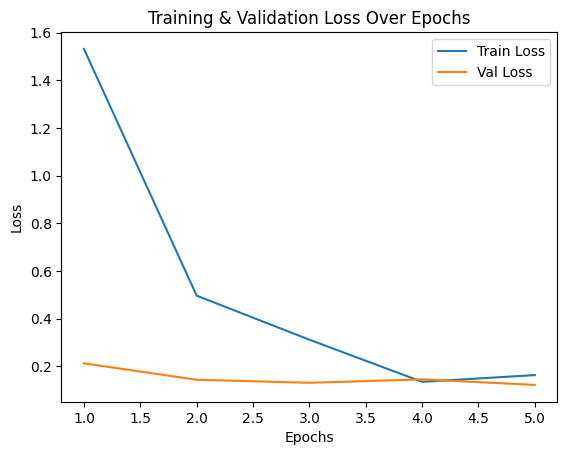

In [49]:
myVgg16.fit(epochs=5,plot_loss=True)

In [50]:
myVgg16.calculate_accuracy()

AttributeError: 'model_tuning' object has no attribute 'test_loader'

In [51]:
torch.save(myVgg16.model.state_dict(),'vgg16_best_leaf.pth')

In [55]:
torch.save(myVgg16.model,'vgg16_best_leaf_model.pth')

In [53]:
from google.colab import files

files.download('vgg16_best_leaf.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
import json
with open("class_mapping.json", "w") as f:
    json.dump(train_dataset.class_to_idx, f)